In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'font.size': 8})

# 活化函數大清點 (pytorch)

支援python 版本: 3.5以上
支援pytorch: 1.4以上

In [2]:
import gc
import glob
import os
import time
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.layers.pytorch_activations import __all__

trident 0.7.4


Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Pytorch version:1.7.1+cu110.
Automatic Mixed Precision Support:True.


Opencv version:4.1.2.
Pillow version:8.2.0.


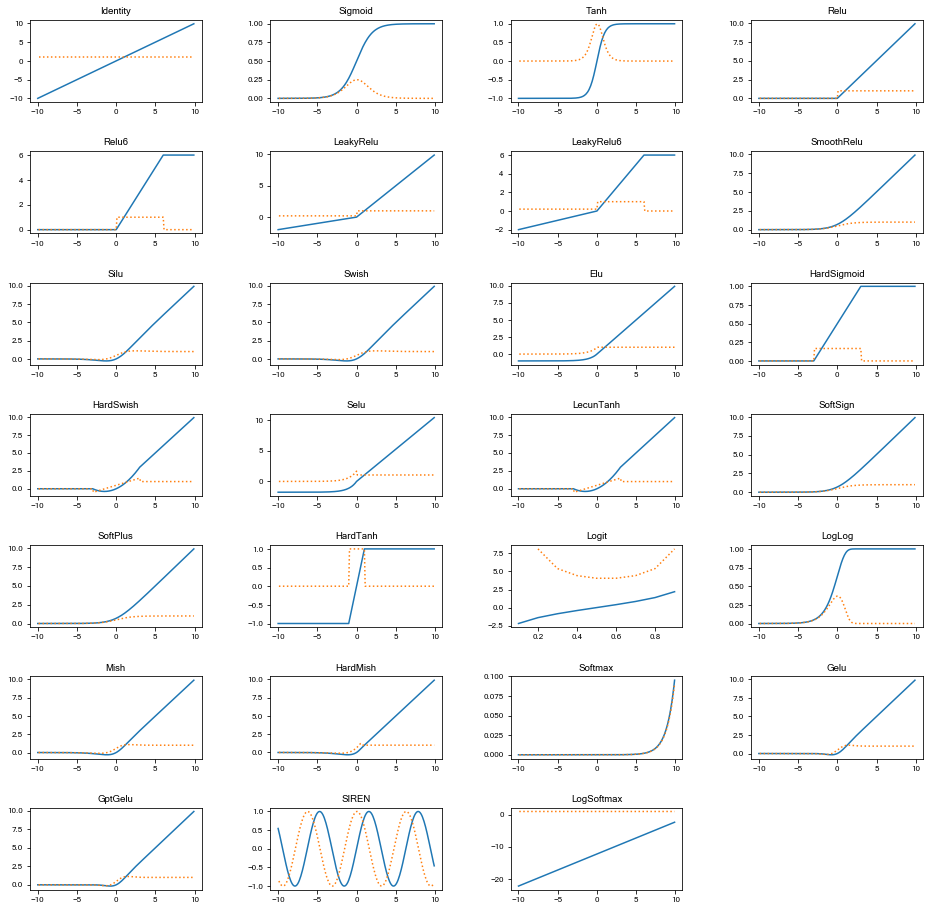

In [3]:

fig = plt.figure(figsize=(16, 16))
plt.ion()
plt.subplots_adjust(wspace=0.4, hspace=0.6)
n = 1
items = __all__[:-1]  # 取得活化函數名稱清單

for k in items:
    if k not in ('PRelu','CRelu'):
        try:
            act_fn = get_activation(k)
            x = np.arange(-10, 10, 0.1).astype(np.float32) # 產生從-10到10之間，每隔0.1一筆的向量(x)
            tensor_x = expand_dims(to_tensor(x),0)  # 向量轉tensor
            y = to_numpy(act_fn(tensor_x))[0]  # 計算向量經過活化函數的結果(y)
            ax1 = fig.add_subplot(7, 4, n)  # 宣告7*4個子圖
            ax1.plot(x, y)  # 將x,y繪製圖表
            ax1.plot(x[1:], np.diff(y) / (np.diff(x) + 1e-8), ls=':')  # np.diff在計算隔一筆的差異。將y的微小變化除以x的微小變化就是梯度
            ax1.set_title(k)

        except Exception as e:
            print(e)
            pass
        n += 1
display.display(fig)  # 將圖表顯示在notebook上
plt.close(fig)  # 把figure關閉，免得出現一堆關不掉的窗口

接下來我們想要評測一下幾個傳統活化函數與新的活化函數之間的效能差異，我們將從幾點來評估它:
1.  計算時長(表示計算的開銷)
2. 跑 mnist 1000 minibatch 的訓練階段最佳accuracy以及最後10個批次的accuracy
3. 使用一樣的數據進行推論
4. 使用加入大量噪聲的數據進行推論(確認跑出來模型的通用性)
5. 檢視訓練過程的梯度與權重分布
6. 梯度為零比率

下面的語法是使用trident API 讀取mnist數據集
你也可以換成T.load_mnist('fashion-mnist')來改讀取fashion mnist

archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping class_names  in en-US   success, total 10 class names added.
(8, 1, 28, 28)


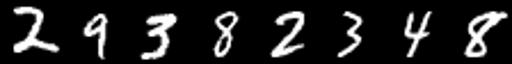

In [4]:
data_provider=T.load_mnist('mnist')   #取得mnist數據集

im,label=data_provider.next() #調用一次以獲取一個minibatch的數據與標籤
print(im.shape)
im=array2image(np.concatenate(im[:8],axis=2)).resize((64*8,64))
#取8筆，把形狀reshapet成(8,28,28)且反正規化，並且沿著寬的方向(axis=1)疊合，並且把圖片尺寸放大到(64*8,64)

data_provider.image_transform_funcs=[Normalize(127.5,127.5)]  #利用減127.5除以127.5的方式來正規化圖片向量(值域會落在正負1之間)
im


若是要產生加入高度噪聲的數據，只需要在noise_dataset.image_transform_funcs中多加入個add_noise(intensity=0.3)，表示會加入30% 強度的隨機噪音，我們將它產生的數據輸出看一下，會是如下圖的結果，使用他的目的在於用乾淨的數據訓練，看看它第一次遇到那麼髒的數據的效度會有多大的程度衰退。

archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping class_names  in en-US   success, total 10 class names added.
(8, 1, 28, 28)


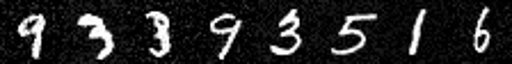

In [5]:
noise_data_provider=T.load_mnist('mnist')#取得mnist數據集
noise_data_provider.image_transform_funcs=[AddNoise(intensity=0.3)]
noise_im,noise_label=noise_data_provider.next() #調用一次以獲取一個minibatch的數據與標籤
print(noise_im.shape)
noise_im=array2image(np.concatenate(noise_im[:8],axis=2)).resize((64*8,64))
#取8筆，把形狀reshapet成(8,28,28)且反正規化，並且沿著寬的方向(axis=1)疊合，並且把圖片尺寸放大到(64*8,64)
noise_data_provider.image_transform_funcs=[AddNoise(intensity=0.3),Normalize(127.5,127.5)]#除了正規化之外`,，額外添加30%噪音    
noise_im

我們這次選擇測試用的活化函數包括了較為傳統的relu, leaky_relu，tanh以及sigmoid，同時也比較了幾個新生代的活化函數，包括了selu,swish,mish以及bert版的gelu。 

In [6]:
activations=['relu','leaky_relu','sigmoid','tanh','selu','swish','mish','gelu','SIREN']
performance_dict=OrderedDict()

接下來就把要測試的目標包裝成測試函數

In [7]:

def test_activity_function(act):
    performance_dict[act]=OrderedDict()
    #清掉記憶體垃圾以避免影響效能
    gc.collect()
    act_func=get_activation(act)
    print(act)
    
    #計算跑 10 萬次的總時間
    data =to_tensor(np.random.standard_normal((100000,1))) 
    start = time.time()
    results=[act_func(data[i]) for  i  in range(100000)]
    sec = time.time() - start
    print('{0:.6f} sec'.format(sec))
    performance_dict[act]['跑 10 萬次的總時間']=sec

    #建 mnist模
    net=Sequential(
    Flatten(),
    Dense(128,use_bias=False,activation=act),
    Dense(64,use_bias=False,activation=act),
    Dense(10,use_bias=False,activation=None),
    SoftMax())
    
    model=Model(input_shape=(1,28,28),output=net)\
    .with_optimizer(optimizer='SGD',lr=1e-3)\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy)
    
    plan=TrainingPlan()\
    .add_training_item(model)\
    .with_data_loader(data_provider)\
    .with_batch_size(128)\
    .print_progress_scheduling(100,unit='batch')\

    #讓他跑1000 次，過程中的權重變化與梯度變化都保留
    plan.only_steps(num_steps=1000,collect_data_inteval=10,keep_weights_history=True,keep_gradient_history=True )
    
    loss_indexs,loss_values=model.training_context['losses'].get_series('total_losses')
    accuracy_indexs,accuracy_values=model.training_context['metrics'].get_series('accuracy')
    print('最低 loss {0:.4e}  最佳 metrics {1:.4%}  最後10次 metrics {2:.4%}'.format(np.array(loss_values).min(),
                                                                              np.array(accuracy_values).max(),
                                                                              np.array(accuracy_values)[-10:].mean()))
    performance_dict[act]['最佳 metrics'] =np.array(accuracy_values).max()
    performance_dict[act]['最後10次 metrics'] =np.array(accuracy_values)[-10:].mean()
    
    
    # 分別使用乾淨數據與噪聲數據進行推論
    net.eval()
    accuracys=[]
    for i in range(100):
        input,target=data_provider.next()
        input,target=to_tensor(input),to_tensor(target)
        accuracys.append(to_numpy(accuracy(net(input),target)))
    accuracys=np.asarray(accuracys)
        
    print('正常樣本 accuracy {0:.4%}  DIFF: {1:.4%} '.format(accuracys.mean(),accuracys.mean()-performance_dict[act]['最後10次 metrics']))
    performance_dict[act]['正常樣本 accuracy DIFF']=accuracys.mean()-performance_dict[act]['最後10次 metrics']
    
    
    noise_accuracys=[]
    for i in range(100):
        input,target=noise_data_provider.next()
        input,target=to_tensor(input),to_tensor(target)
        noise_accuracys.append(to_numpy(accuracy(net(input),target)))
    noise_accuracys=np.asarray(noise_accuracys)
        
    print('噪聲樣本 accuracy {0:.4%}  DIFF: {1:.4%} '.format(noise_accuracys.mean(),noise_accuracys.mean()-performance_dict[act]['最後10次 metrics']))
    performance_dict[act]['噪聲樣本 accuracy DIFF']=noise_accuracys.mean()-performance_dict[act]['最後10次 metrics']
    
    #繪製梯度與權重分布
    weights_history=plan.training_items[0].weights_history
    gradients_history=plan.training_items[0].gradients_history
    
    grads=[]
    weights=[]
    for i in range(len(gradients_history)):
        grads.append(gradients_history[i].value_list[0].reshape([-1]))

    for i in range(len(weights_history)):
         weights.append(weights_history[i].value_list[0].reshape([-1]))
    
    grads=np.asarray(grads)
    weights=np.asarray(weights)
    #計算梯度為零比例
    print('梯度為零比例 : {0:.3%}'.format(np.equal(grads,0).astype(np.float32).mean()))
    performance_dict[act]['梯度為零比例']=np.equal(grads,0).astype(np.float32).mean()
    performance_dict[act]['負梯度比例']=np.less(grads,0).astype(np.float32).mean()
    
    steps_histogram(grads,weights,inteval=50,imshow=True)
    
    
    fig = plt.figure(figsize=(18,8))
    for i in [1,2]:
        ax= fig.add_subplot(1, 2, i, projection = '3d')


        # Make data.
        X = np.arange(0, 28, 1)
        Y = np.arange(0, 28, 1)
        X, Y = np.meshgrid(X, Y)
        grad_grid=gradients_history[0 if i==1 else-1].value_list[0][0,:].reshape([28,28])
        Z = grad_grid[Y,X]

        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

        # Customize the z axis.
        ax.set_zlim(grad_grid.min()*1.1,grad_grid.max()*1.1)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

        fig.colorbar(surf, shrink=0.5, aspect=5)

    display.display(plt.gcf())
    plt.close(fig)
   

relu
6.252835 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for model 0 :{ input: image, output: output, target: label }
{ CrossEntropyLoss: 2.310, total_losses: 2.310 }
model 0      Step: 1s522ms  | Loss: 2.303 | accuracy: 8.410%  | lr: 1.000e-03  | epoch: 0  ( 100/1000 )
model 0      Step: 1s595ms  | Loss: 2.293 | accuracy: 10.822%  | lr: 1.000e-03  | epoch: 0  ( 200/1000 )
model 0      Step: 1s447ms  | Loss: 2.284 | accuracy: 14.346%  | lr: 1.000e-03  | epoch: 0  ( 300/1000 )
model 0      Step: 1s628ms  | Loss: 2.276 | accuracy: 18.161%  | lr: 1.000e-03  | epoch: 0  ( 400/1000 )
model 0      Step: 1s265ms  | Loss: 2.268 | accuracy: 21.828%  | lr: 1.000e-03  | epoch: 0  ( 500/1000 )
model 0      Step: 1s538ms  | Loss: 2.260 | accuracy: 24.895%  | lr: 1.000e-03  | epoch: 0  ( 600/1000 )
model 0      Step: 1s219ms  | Loss: 2.251 | accuracy: 27.642%  | lr: 1.000e-03  | epoch: 0  ( 700/1000 )
model 0      Step: 1s221ms  | Loss

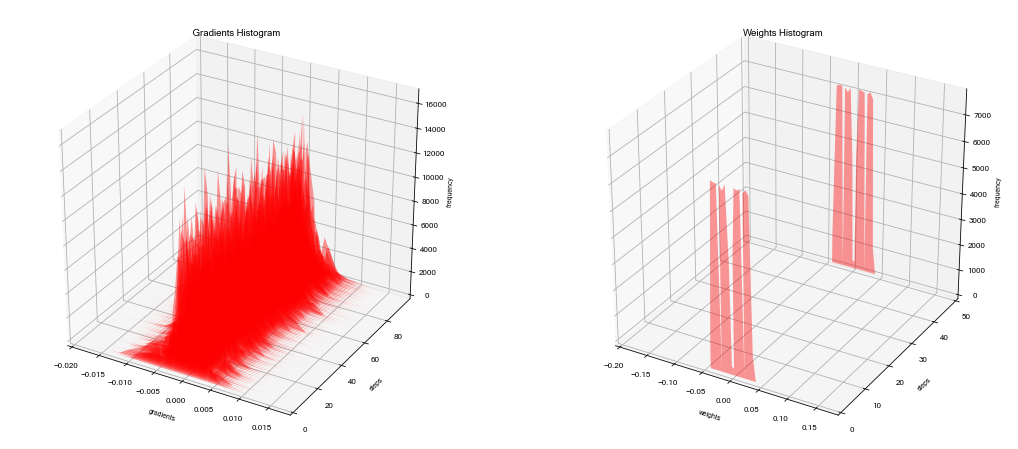

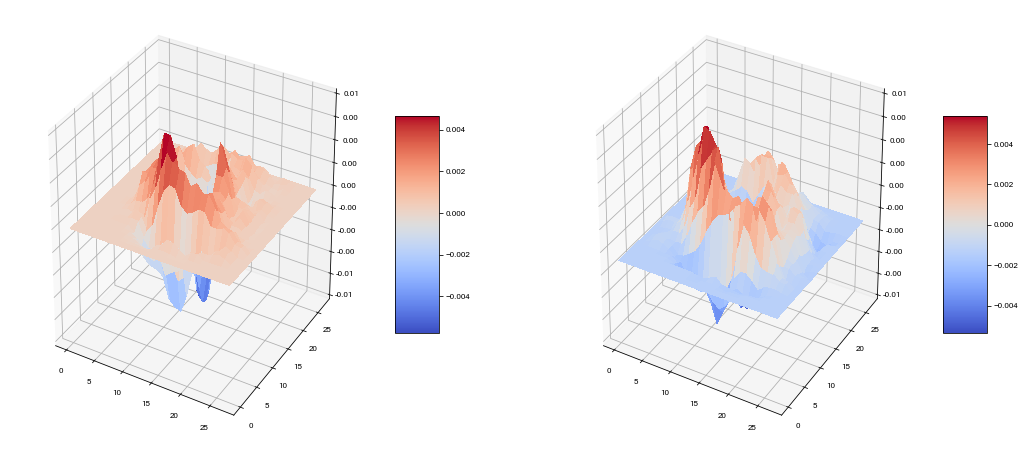

In [8]:
test_activity_function('relu')

leaky_relu
8.084110 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for model 0 :{ input: image, output: output, target: label }
{ CrossEntropyLoss: 2.304, total_losses: 2.304 }
model 0      Step: 1s369ms  | Loss: 2.294 | accuracy: 12.021%  | lr: 1.000e-03  | epoch: 0  ( 100/1000 )
model 0      Step: 1s391ms  | Loss: 2.286 | accuracy: 11.929%  | lr: 1.000e-03  | epoch: 0  ( 200/1000 )
model 0      Step: 1s539ms  | Loss: 2.277 | accuracy: 13.100%  | lr: 1.000e-03  | epoch: 0  ( 300/1000 )
model 0      Step: 1s347ms  | Loss: 2.269 | accuracy: 15.537%  | lr: 1.000e-03  | epoch: 0  ( 400/1000 )
model 0      Step: 1s541ms  | Loss: 2.260 | accuracy: 18.859%  | lr: 1.000e-03  | epoch: 0  ( 500/1000 )
model 0      Step: 1s395ms  | Loss: 2.251 | accuracy: 22.147%  | lr: 1.000e-03  | epoch: 0  ( 600/1000 )
model 0      Step: 1s196ms  | Loss: 2.242 | accuracy: 25.138%  | lr: 1.000e-03  | epoch: 0  ( 700/1000 )
model 0      Step: 1s195ms 

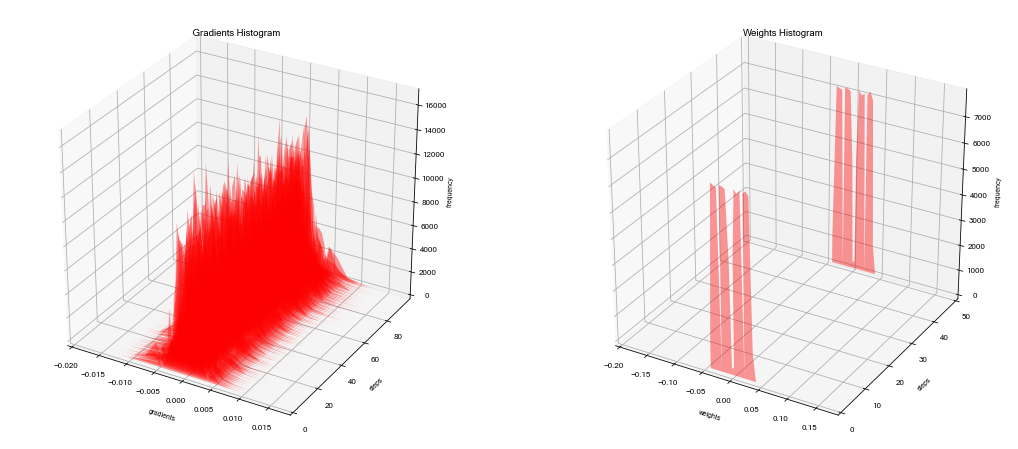

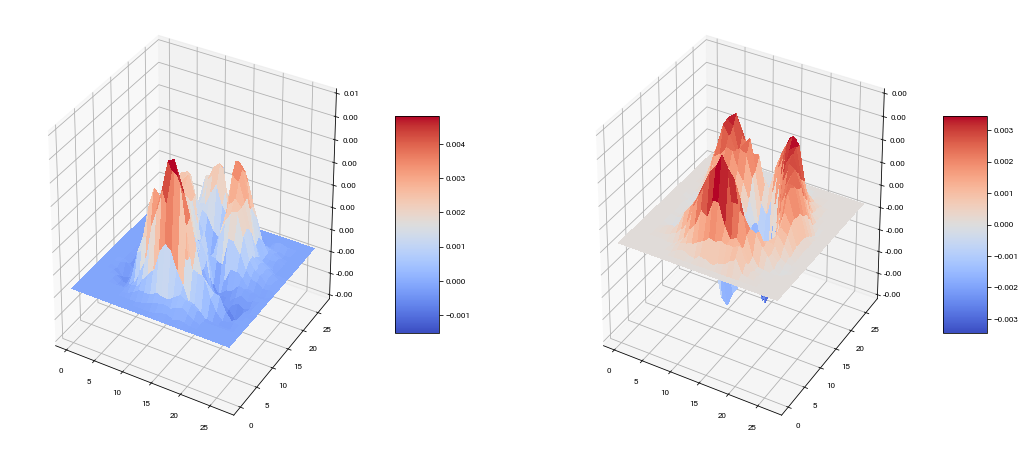

In [9]:
test_activity_function('leaky_relu')

sigmoid
5.060971 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for model 0 :{ input: image, output: output, target: label }
{ CrossEntropyLoss: 2.333, total_losses: 2.333 }
model 0      Step: 1s207ms  | Loss: 2.321 | accuracy: 10.604%  | lr: 1.000e-03  | epoch: 0  ( 100/1000 )
model 0      Step: 1s239ms  | Loss: 2.320 | accuracy: 10.459%  | lr: 1.000e-03  | epoch: 0  ( 200/1000 )
model 0      Step: 1s415ms  | Loss: 2.317 | accuracy: 10.538%  | lr: 1.000e-03  | epoch: 0  ( 300/1000 )
model 0      Step: 1s517ms  | Loss: 2.314 | accuracy: 10.586%  | lr: 1.000e-03  | epoch: 0  ( 400/1000 )
model 0      Step: 1s272ms  | Loss: 2.312 | accuracy: 10.484%  | lr: 1.000e-03  | epoch: 0  ( 500/1000 )
model 0      Step: 1s407ms  | Loss: 2.311 | accuracy: 10.451%  | lr: 1.000e-03  | epoch: 0  ( 600/1000 )
model 0      Step: 1s169ms  | Loss: 2.310 | accuracy: 10.448%  | lr: 1.000e-03  | epoch: 0  ( 700/1000 )
model 0      Step: 1s121ms  | 

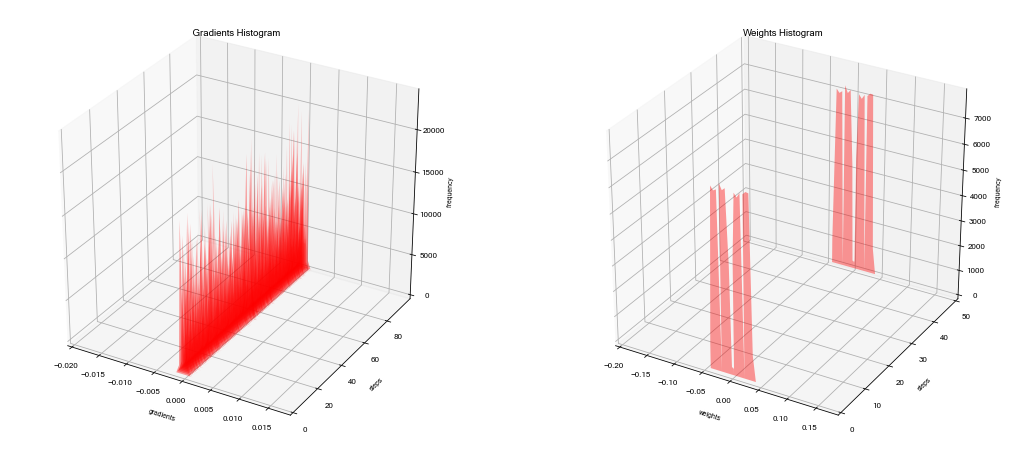

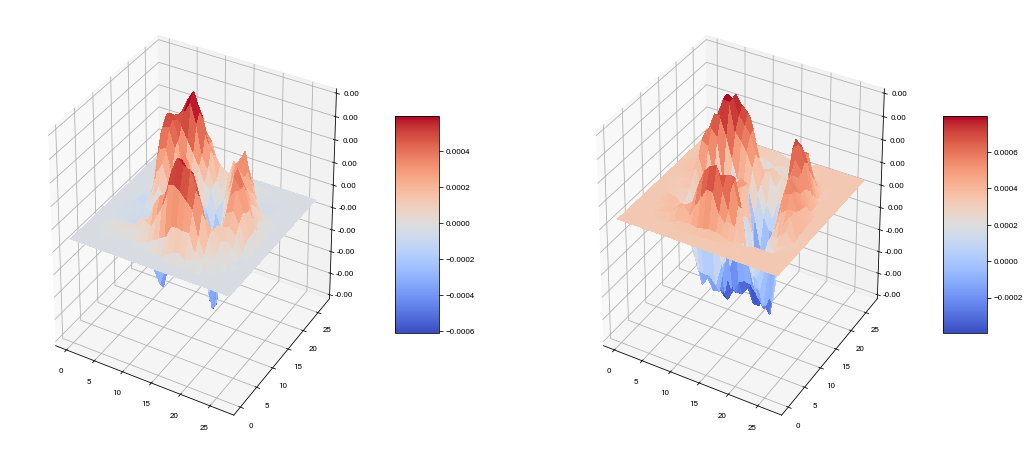

In [10]:
test_activity_function('sigmoid')

tanh
5.678152 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for model 0 :{ input: image, output: output, target: label }
{ CrossEntropyLoss: 2.334, total_losses: 2.334 }
model 0      Step: 1s238ms  | Loss: 2.310 | accuracy: 10.175%  | lr: 1.000e-03  | epoch: 0  ( 100/1000 )
model 0      Step: 1s253ms  | Loss: 2.286 | accuracy: 13.859%  | lr: 1.000e-03  | epoch: 0  ( 200/1000 )
model 0      Step: 1s530ms  | Loss: 2.266 | accuracy: 19.251%  | lr: 1.000e-03  | epoch: 0  ( 300/1000 )
model 0      Step: 1s916ms  | Loss: 2.246 | accuracy: 23.324%  | lr: 1.000e-03  | epoch: 0  ( 400/1000 )
model 0      Step: 1s610ms  | Loss: 2.227 | accuracy: 27.085%  | lr: 1.000e-03  | epoch: 0  ( 500/1000 )
model 0      Step: 1s604ms  | Loss: 2.208 | accuracy: 30.566%  | lr: 1.000e-03  | epoch: 0  ( 600/1000 )
model 0      Step: 1s742ms  | Loss: 2.188 | accuracy: 33.845%  | lr: 1.000e-03  | epoch: 0  ( 700/1000 )
model 0      Step: 1s703ms  | Los

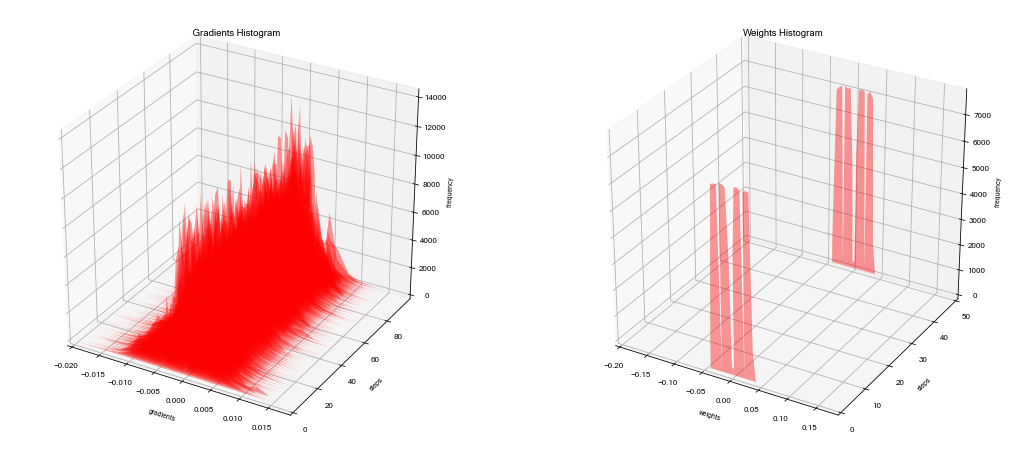

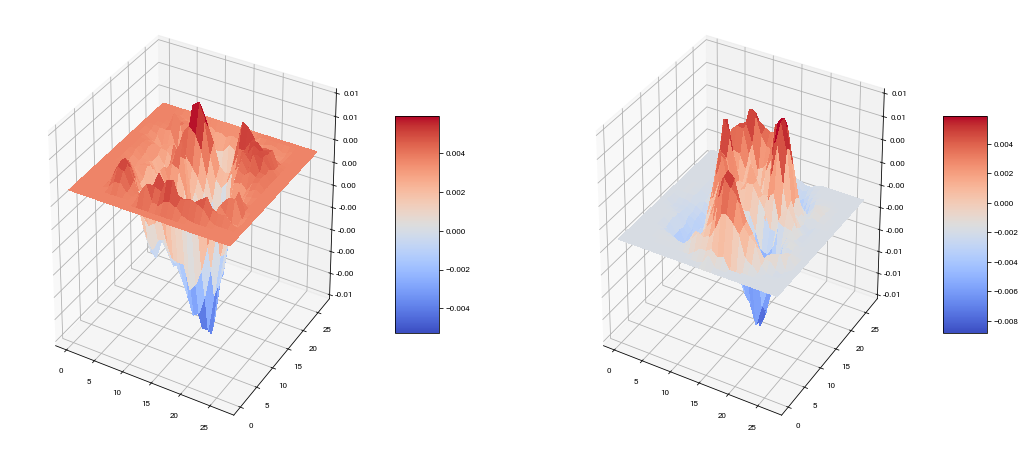

In [11]:
test_activity_function('tanh')

selu
10.492671 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for model 0 :{ input: image, output: output, target: label }
{ CrossEntropyLoss: 2.337, total_losses: 2.337 }
model 0      Step: 1s953ms  | Loss: 2.279 | accuracy: 12.977%  | lr: 1.000e-03  | epoch: 0  ( 100/1000 )
model 0      Step: 1s827ms  | Loss: 2.218 | accuracy: 23.055%  | lr: 1.000e-03  | epoch: 0  ( 200/1000 )
model 0      Step: 2s676ms  | Loss: 2.163 | accuracy: 32.288%  | lr: 1.000e-03  | epoch: 0  ( 300/1000 )
model 0      Step: 2s135ms  | Loss: 2.110 | accuracy: 39.287%  | lr: 1.000e-03  | epoch: 0  ( 400/1000 )
model 0      Step: 1s479ms  | Loss: 2.057 | accuracy: 44.559%  | lr: 1.000e-03  | epoch: 0  ( 500/1000 )
model 0      Step: 1s697ms  | Loss: 2.004 | accuracy: 48.569%  | lr: 1.000e-03  | epoch: 0  ( 600/1000 )
model 0      Step: 1s276ms  | Loss: 1.952 | accuracy: 51.810%  | lr: 1.000e-03  | epoch: 0  ( 700/1000 )
model 0      Step: 1s176ms  | Lo

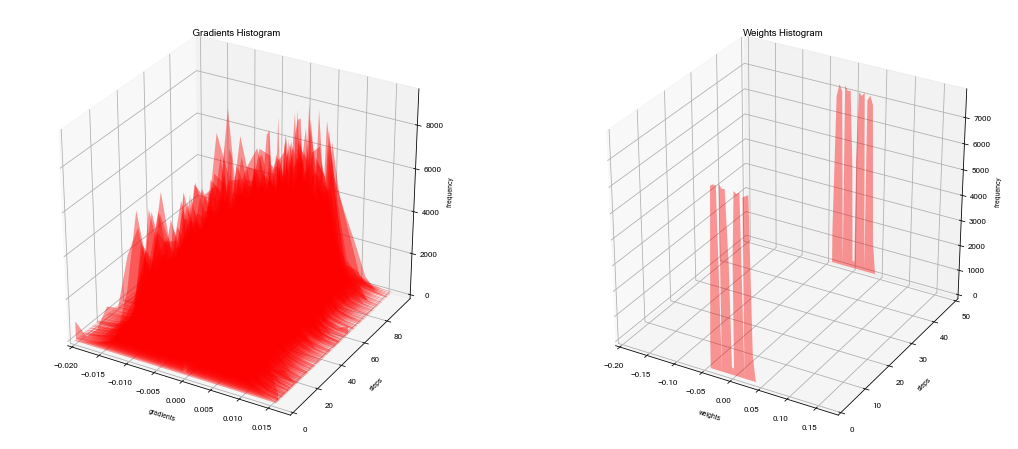

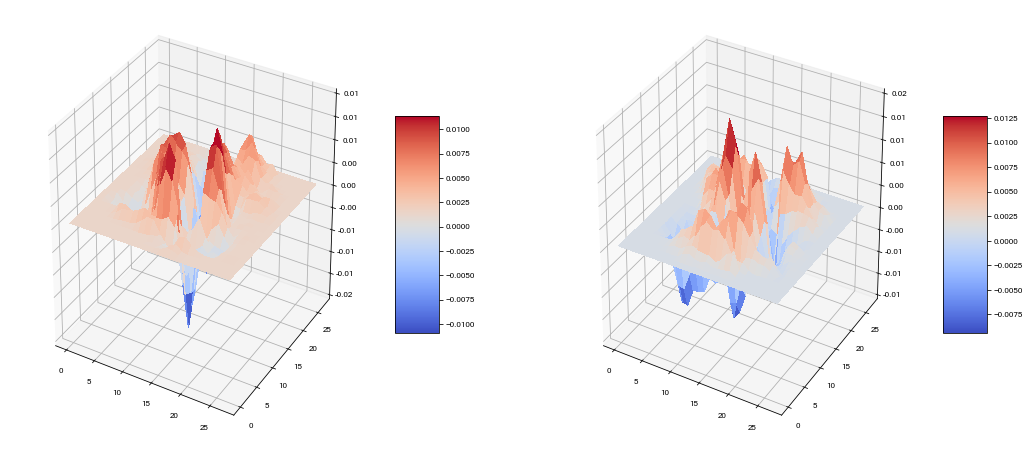

In [12]:
test_activity_function('selu')

swish
18.731727 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for model 0 :{ input: image, output: output, target: label }
{ CrossEntropyLoss: 2.305, total_losses: 2.305 }
model 0      Step: 1s981ms  | Loss: 2.301 | accuracy: 10.743%  | lr: 1.000e-03  | epoch: 0  ( 100/1000 )
model 0      Step: 1s290ms  | Loss: 2.299 | accuracy: 12.067%  | lr: 1.000e-03  | epoch: 0  ( 200/1000 )
model 0      Step: 1s780ms  | Loss: 2.296 | accuracy: 13.273%  | lr: 1.000e-03  | epoch: 0  ( 300/1000 )
model 0      Step: 1s195ms  | Loss: 2.294 | accuracy: 15.043%  | lr: 1.000e-03  | epoch: 0  ( 400/1000 )
model 0      Step: 1s236ms  | Loss: 2.291 | accuracy: 17.668%  | lr: 1.000e-03  | epoch: 0  ( 500/1000 )
model 0      Step: 1s304ms  | Loss: 2.289 | accuracy: 20.204%  | lr: 1.000e-03  | epoch: 0  ( 600/1000 )
model 0      Step: 1s755ms  | Loss: 2.286 | accuracy: 22.272%  | lr: 1.000e-03  | epoch: 0  ( 700/1000 )
model 0      Step: 1s469ms  | L

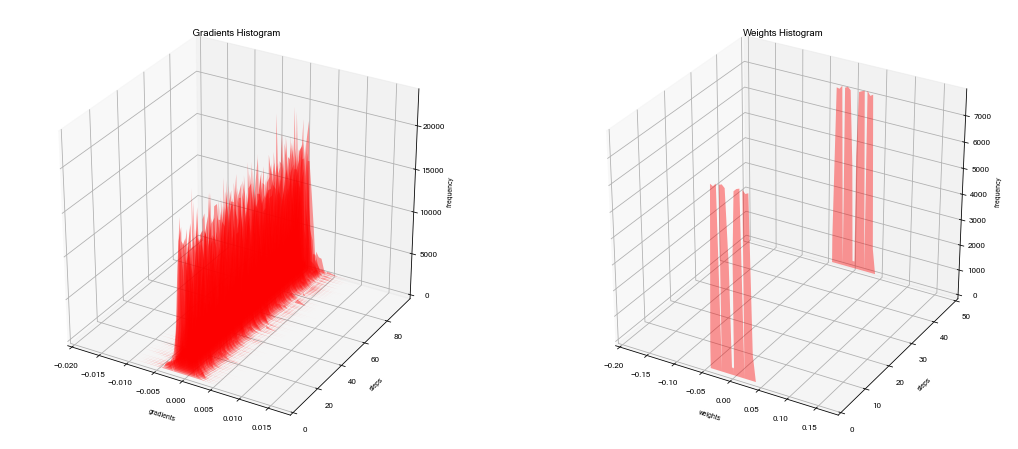

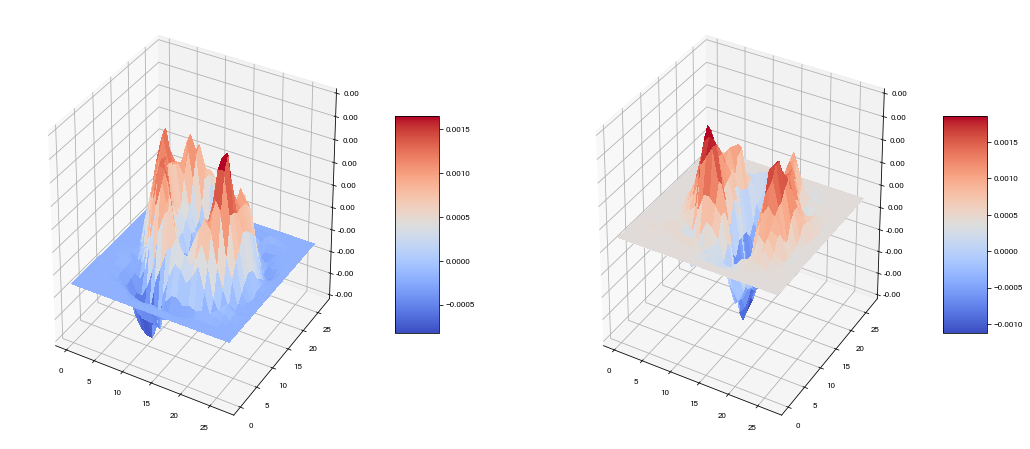

In [13]:
test_activity_function('swish')

mish
8.775042 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for model 0 :{ input: image, output: output, target: label }
{ CrossEntropyLoss: 2.311, total_losses: 2.311 }
model 0      Step: 1s156ms  | Loss: 2.295 | accuracy: 11.758%  | lr: 1.000e-03  | epoch: 0  ( 100/1000 )
model 0      Step: 1s130ms  | Loss: 2.289 | accuracy: 13.624%  | lr: 1.000e-03  | epoch: 0  ( 200/1000 )
model 0      Step: 1s204ms  | Loss: 2.283 | accuracy: 14.309%  | lr: 1.000e-03  | epoch: 0  ( 300/1000 )
model 0      Step: 1s379ms  | Loss: 2.277 | accuracy: 15.099%  | lr: 1.000e-03  | epoch: 0  ( 400/1000 )
model 0      Step: 1s549ms  | Loss: 2.271 | accuracy: 15.947%  | lr: 1.000e-03  | epoch: 0  ( 500/1000 )
model 0      Step: 1s367ms  | Loss: 2.265 | accuracy: 16.792%  | lr: 1.000e-03  | epoch: 0  ( 600/1000 )
model 0      Step: 1s296ms  | Loss: 2.259 | accuracy: 17.811%  | lr: 1.000e-03  | epoch: 0  ( 700/1000 )
model 0      Step: 1s302ms  | Los

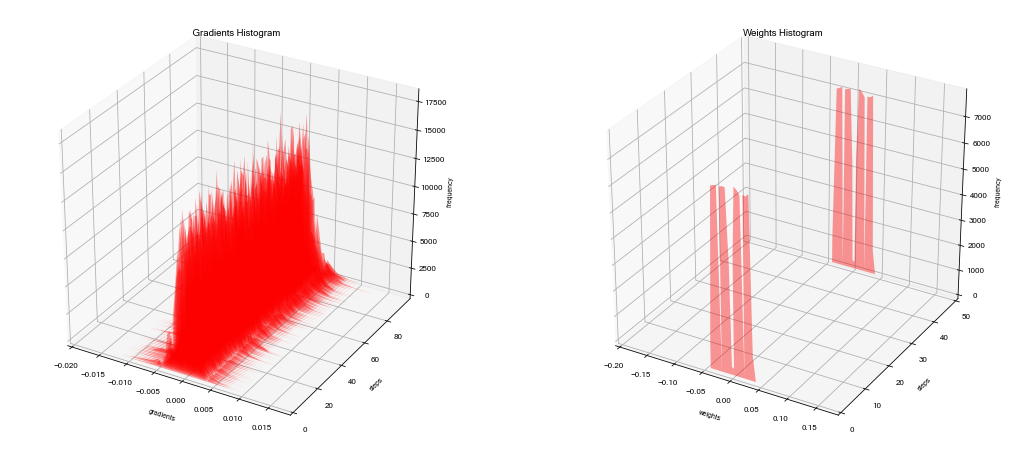

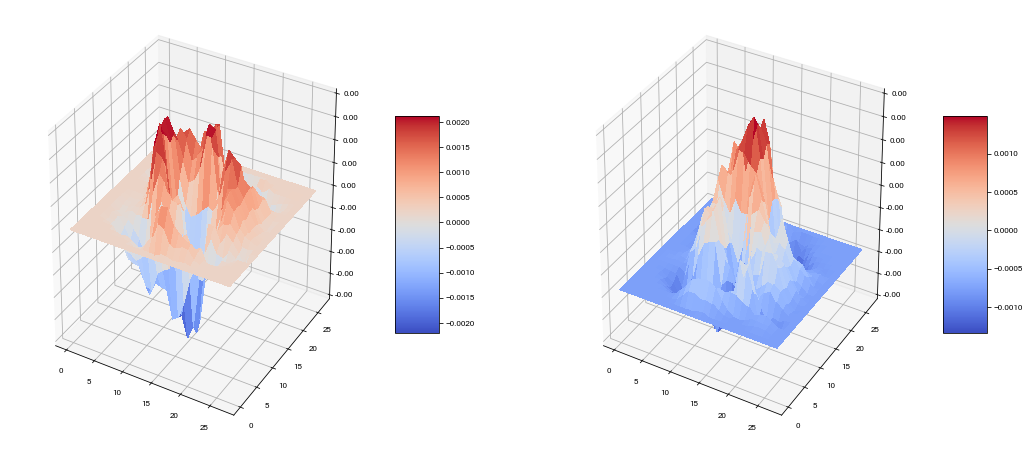

In [14]:
test_activity_function('mish')

gelu
13.328156 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for model 0 :{ input: image, output: output, target: label }
{ CrossEntropyLoss: 2.309, total_losses: 2.309 }
model 0      Step: 1s241ms  | Loss: 2.304 | accuracy: 6.650%  | lr: 1.000e-03  | epoch: 0  ( 100/1000 )
model 0      Step: 1s204ms  | Loss: 2.301 | accuracy: 6.834%  | lr: 1.000e-03  | epoch: 0  ( 200/1000 )
model 0      Step: 1s206ms  | Loss: 2.298 | accuracy: 7.779%  | lr: 1.000e-03  | epoch: 0  ( 300/1000 )
model 0      Step: 1s502ms  | Loss: 2.295 | accuracy: 9.769%  | lr: 1.000e-03  | epoch: 0  ( 400/1000 )
model 0      Step: 1s307ms  | Loss: 2.292 | accuracy: 11.720%  | lr: 1.000e-03  | epoch: 0  ( 500/1000 )
model 0      Step: 1s268ms  | Loss: 2.289 | accuracy: 13.444%  | lr: 1.000e-03  | epoch: 0  ( 600/1000 )
model 0      Step: 1s523ms  | Loss: 2.285 | accuracy: 14.872%  | lr: 1.000e-03  | epoch: 0  ( 700/1000 )
model 0      Step: 1s324ms  | Loss: 

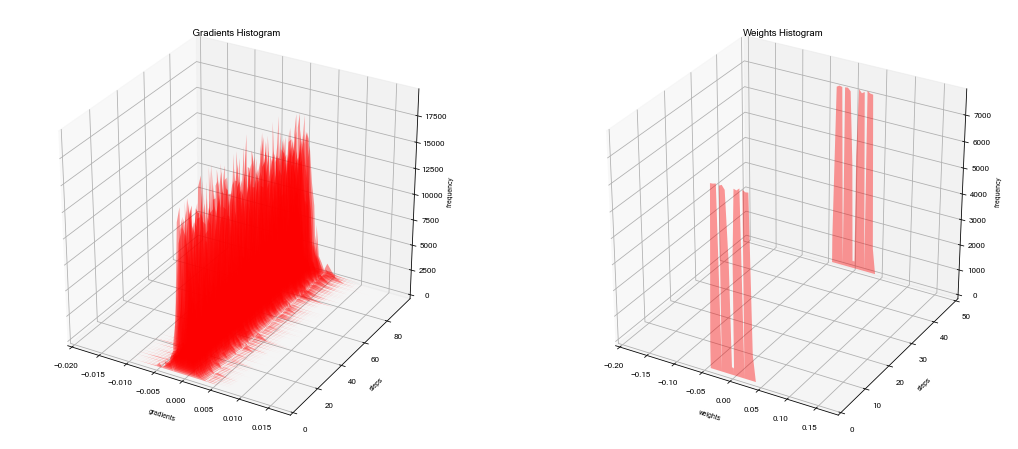

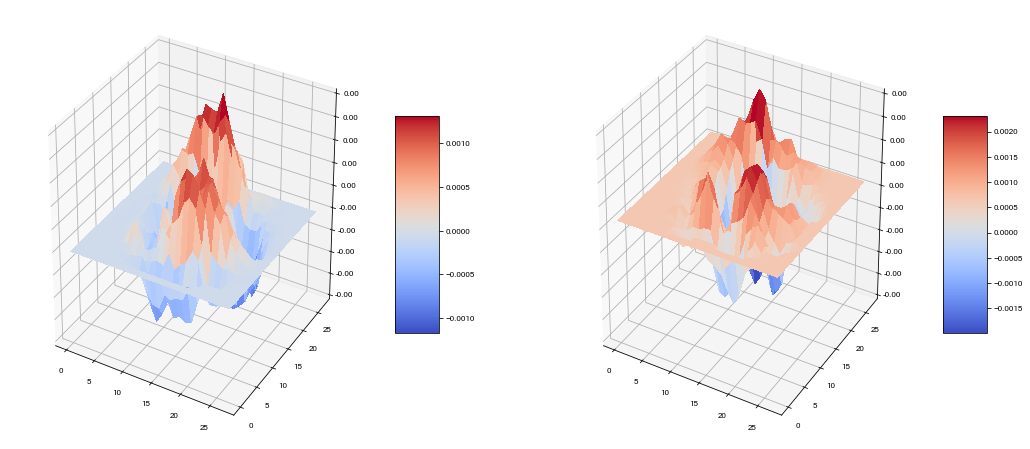

In [15]:
test_activity_function('gelu')

SIREN
13.706508 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for model 0 :{ input: image, output: output, target: label }
{ CrossEntropyLoss: 2.330, total_losses: 2.330 }
model 0      Step: 1s185ms  | Loss: 2.317 | accuracy: 9.346%  | lr: 1.000e-03  | epoch: 0  ( 100/1000 )
model 0      Step: 1s226ms  | Loss: 2.290 | accuracy: 14.286%  | lr: 1.000e-03  | epoch: 0  ( 200/1000 )
model 0      Step: 1s409ms  | Loss: 2.265 | accuracy: 20.219%  | lr: 1.000e-03  | epoch: 0  ( 300/1000 )
model 0      Step: 1s153ms  | Loss: 2.243 | accuracy: 25.088%  | lr: 1.000e-03  | epoch: 0  ( 400/1000 )
model 0      Step: 1s209ms  | Loss: 2.220 | accuracy: 29.370%  | lr: 1.000e-03  | epoch: 0  ( 500/1000 )
model 0      Step: 1s172ms  | Loss: 2.198 | accuracy: 32.975%  | lr: 1.000e-03  | epoch: 0  ( 600/1000 )
model 0      Step: 1s149ms  | Loss: 2.175 | accuracy: 36.142%  | lr: 1.000e-03  | epoch: 0  ( 700/1000 )
model 0      Step: 1s173ms  | Lo

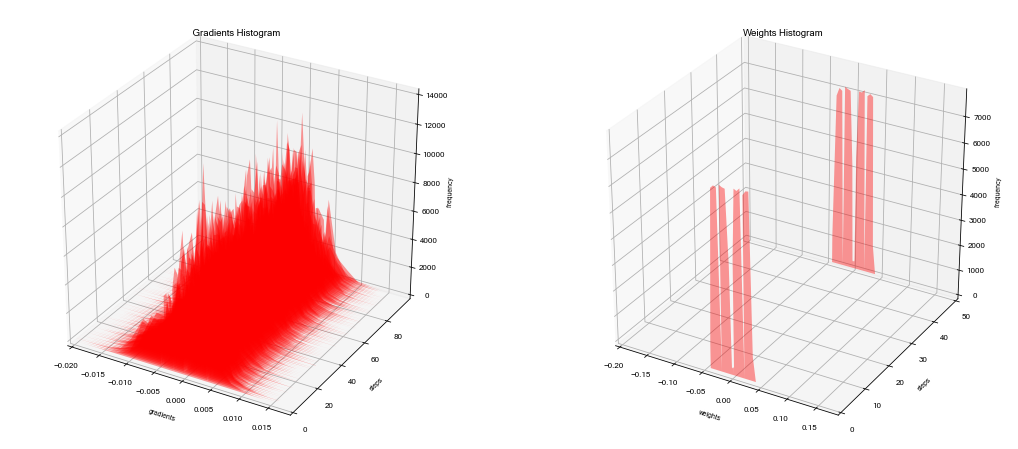

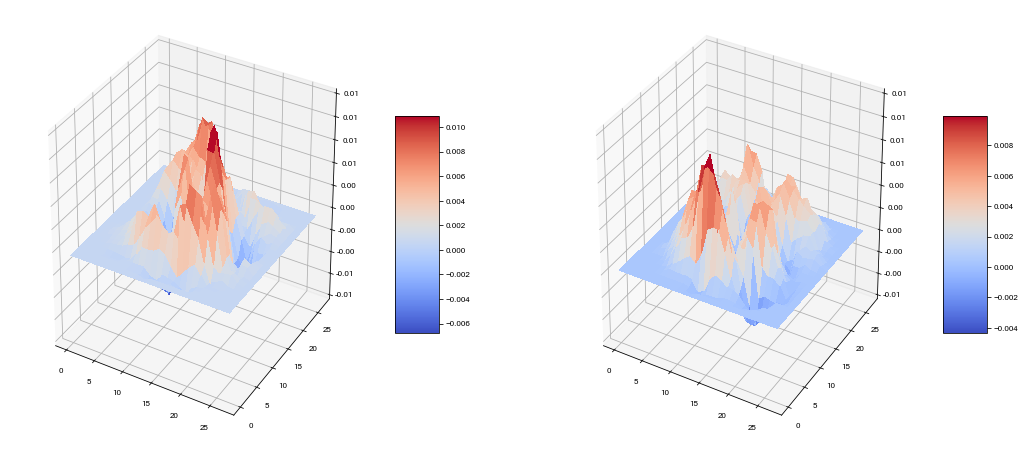

In [16]:
test_activity_function('SIREN')

首先要來看的是這幾個活化函數的計算開銷，我們紀錄每個活化函數各執行1萬次的執行時間長度，我們可以發現gelu的計算開銷是遠大於其他活化函數的。接下來我們想要看看這些模型實際面對測試數據以及面臨到數據品質極差的樣本時，是不是具有足夠的泛化能力。這邊可以看到新生代的活化函數整體上看來，泛化能力是排後段班的。  

接下來我們將收集的梯度與權重歷程(我們是設定collect_data_inteval=100，即每100批次收集一次數據)，首先是看梯度分布的狀況，由於這個直方圖的z軸高度是根據圖表的最大值設定的，因此如果你看到有些圖看起來梯度很稀疏，幾乎看不到紅色區域，那就是它的梯度都集中在特定點(通常是0)，你可以看到relu是全部中梯度為零比例最高者，leaky_relu看起來很有效的緩解了relu梯度為零的缺陷，新生代的活化函數的梯度為零比率看起來表現尚可。

整體來看，新舊各有優點，老實說活化函數的影響其實低於優化器或者是權重初始化，若要我給個結論，我會建議的是：「別再使用relu了，如果你習慣傳統活化函數的低計算開銷，建議改成leaky_relu，如果你想嘗試新的活化函數，selu看起來是比較好的選擇」

In [17]:
import pandas
#將performance_dict轉成表格
pd=pandas.DataFrame.from_dict(performance_dict)
pd

,relu,leaky_relu,sigmoid,tanh,selu,swish,mish,gelu,SIREN
跑 10 萬次的總時間,6.252835,8.084110,5.060971,5.678152,10.492671,18.731727,8.775042,13.328156,13.706508
最佳 metrics,0.355213,0.329710,0.132812,0.426424,0.592772,0.271577,0.211261,0.187997,0.439684
最後10次 metrics,0.345498,0.320787,0.104506,0.416458,0.584687,0.265998,0.207130,0.183588,0.430948
正常樣本 accuracy DIFF,0.231064,0.191088,0.000182,0.231589,0.176875,0.112909,0.120214,0.100240,0.204365
噪聲樣本 accuracy DIFF,0.230752,0.189213,0.011744,0.246042,0.202813,0.112752,0.127870,0.082662,0.184052
梯度為零比例,0.024141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
負梯度比例,0.479212,0.472744,0.508344,0.483959,0.501590,0.468514,0.451549,0.469053,0.496121
